In [3]:
import keras 
from keras import backend as K
from keras import layers
from keras.models import Model
import numpy as np

#  Encoder network

In [8]:
img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2

input_img = keras.Input(shape=img_shape)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)

shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

#  Latent space sampling function

In [9]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var)*epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

#  Decoder Network

In [12]:
decoder_input = layers.Input(shape=K.int_shape(z)[1:])
x = layers.Dense(np.prod(shape_before_flattening[1:]))(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)
decoder = Model(decoder_input, x)
z_decoded = decoder(z)

# Custom VAE loss layer 

In [13]:
class CustomVariationalLayer(keras.layers.Layer):
    
    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss+kl_loss)
    
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x
    
y = CustomVariationalLayer()([input_img, z_decoded])

#  VAE training

In [14]:
from keras.datasets import mnist

vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

(train_images, _) , (test_images, test_targets) = mnist.load_data()

train_images = train_images.astype('float32')/255
test_images = test_images.astype('float32')/255
train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

vae.fit(x=train_images, y=None, shuffle=True, epochs=10, batch_size=batch_size, validation_data=[test_images,None])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 28, 28, 32)   320         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 14, 14, 64)   18496       conv2d_9[0][0]                   
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 14, 14, 64)   36928       conv2d_10[0][0]                  
__________________________________________________________________________________________________
conv2d_12 

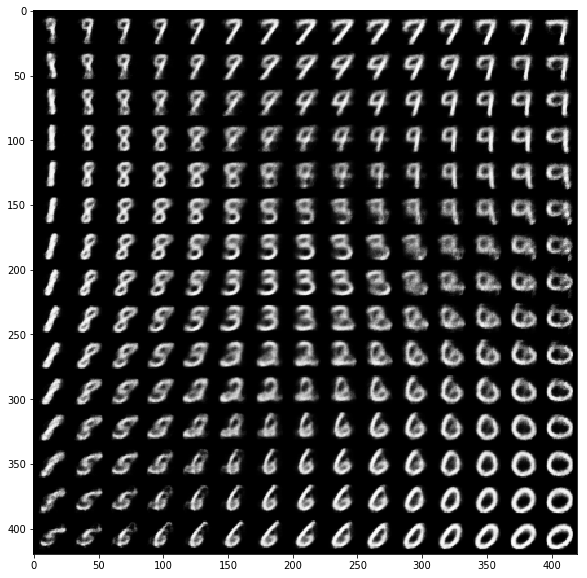

In [17]:
import matplotlib.pyplot as plt
from scipy.stats import norm

n = 15
digit_size = 28
figure = np.zeros((digit_size*n, digit_size*n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i,xi in enumerate(grid_x):
    for j,yi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape((batch_size, 2))
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape((digit_size, digit_size))
        figure[i*digit_size:(i+1)*digit_size, j*digit_size:(j+1)*digit_size] = digit
        
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.imsave('mnist_vae.png', figure)